# New Narratives for old Buildings

---



Finding narratives through comparison of term frequency across countries

In [1]:
import os, re, csv
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from itertools import islice
from nltk.corpus import stopwords
import spacy
import string
import pickle
import matplotlib.pyplot as plt

## Loading the dataset: heritage homes webistes


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
path = '/content/gdrive/MyDrive/CDA/' # working with google drive and colab

# path = 'datasets/' # working locally

In [4]:
# Country code: change here between 'NL' and 'UK'
cc_list = ['NL', 'UK', 'DE', 'FR']

In [5]:
# Import json data from Aipfy scraping into 4 separate dataframes
df0=pd.read_json(path+cc_list[0]+'_dataset_website-content-crawler.json') # NL
# select only two columns for analysis: url and text
df0=df0[['url','text']]

df1=pd.read_json(path+cc_list[1]+'_dataset_website-content-crawler.json') # UK
# select only two columns for analysis: url and text
df1=df1[['url','text']]

df2=pd.read_json(path+cc_list[2]+'_dataset_website-content-crawler.json') # DE
# select only two columns for analysis: url and text
df2=df2[['url','text']]

df3=pd.read_json(path+cc_list[3]+'_dataset_website-content-crawler.json') # FR
# select only two columns for analysis: url and text
df3=df3[['url','text']]

df0.head()

,url,text
0,http://weldam.nl/,"Introduction - Weldam\nIntroduction\nWeldam, s..."
1,http://weldam.nl/nederlands.html,Nederlands - Weldam\nCopyright Landgoed Weldam...
2,http://weldam.nl/nederlands/beginpagina/test-2...,Test 1.2 - Weldam\nCopyright Landgoed Weldam 2...
3,https://www.huisdoorn.nl/,Ontdek de geschiedenis - Museum Huis Doorn\nDe...
4,https://www.museumdefundatie.nl/,Museum de FundatieTwitter Widget Iframe\nMuseu...


In [7]:
# check if there are further datasets to add per country

!ls "$path" | grep "^NL_"

NL_dataset_website-content-crawler.json
NL_LG_dataset_website-content-crawler_2025-02-06_09-40-33-880.json


In [9]:
# manually append additional datasets (based on previous step)
df_missing1 = pd.read_json(path+'/NL_LG_dataset_website-content-crawler_2025-02-06_09-40-33-880.json')
result = pd.concat([df0, df_missing1])

In [ ]:
df_missing1 = pd.read_json(path+'/UK_EH_dataset_website-content-crawler_2025-03-18_13-49-50-417.json')
df_missing2 = pd.read_json(path+'/UK_PC_dataset_website-content-crawler_2025-03-11_12-28-08-810.json')
result = pd.concat([df1, df_missing1, df_missing2])

Join all pages from a domain to an entry in the analysis. To do this, add a new column which will contain only the main domain name.

In [10]:
# function to extract the main domain from the url in the dataset
def extract_main_domain(url):
    if not isinstance(str(url), str):
        print('NOT VALID',url)
        return None
    match = re.findall('(?m)http(?:s?):\/\/.*?([^\.\/]+?\.[^\.]+?)(?:\/|$)', str(url)) #'www\.?([^/]+)'
    return match[0].lstrip('www.') if match else None

In [12]:
# Add a new column 'domain' and fill it by applying the extract_main_domain function to the 'url' column

# first, create a mapping of dataframes which could be addressed in a loop
df_dict = {'0':df0, '1':df1, '2':df2, '3':df3}

# then, loop through the df_dict to update each dataframe
for k, v in df_dict.items():
  cc_column = cc_list[int(k[-1])]+' domains'
  cc = cc_list[int(k[-1])]
  # print(cc_column, cc)
  urls = pd.read_csv(path+'url_lists/'+cc_list[int(k[-1])]+'_urls.csv')[cc_column].values.tolist()
  domains = {extract_main_domain(url) for url in urls if extract_main_domain(url) is not None}
  matching_links = [link for link in v.url if extract_main_domain(link) in domains]
  # update the dataframe
  v['domain'] = v['url'].apply(extract_main_domain)

In [15]:
# check one of the dataframes
df2.head()

,url,text,domain
0,http://www.schlossparkmarisfeld.de/,Schlosspark Marisfeld - Schlosspark Marisfeld\...,schlossparkmarisfeld.de
1,http://www.schlossparkmarisfeld.de/information...,Informationen zur Geschichte des Schlossparks\...,schlossparkmarisfeld.de
2,http://www.schlossparkmarisfeld.de/information...,Der Schlosspark Marisfeld - Kleine Parkgeschic...,schlossparkmarisfeld.de
3,http://www.schlossparkmarisfeld.de/information...,Der Förderverein stellt sich vor\nDer aktuelle...,schlossparkmarisfeld.de
4,http://www.schlossparkmarisfeld.de/information...,Die Vereinssatzung - Schlosspark Marisfeld\nFa...,schlossparkmarisfeld.de


## Compare term frequencies across corpora

In [101]:
# list terms to compare
activities = ['kind','spel','avontuur',
              'child','game','adventure',
              'kind', 'spiel', 'abenteuer',
              'enfant', 'jeu', 'aventure']
events = ['feest','bruiloft','bruid','bruidegom',
          'party','wedding','bride','groom',
          'party', 'hochzeit', 'braut', 'bräutigam',
          'fête', 'mariage', 'mariée', 'marié']
nobility = ['graaf','baron','hertog',
            'earl','baron','duke',
            'graf','baron','herzog',
            'compte','baron','duc']
culture = ['','','','','','',
           'exhibition','museum','garden','park','tour','collection',
           '','','','','','',
           '','','','','','']
styles = ['rococo', 'barok', 'renaissance', 'gotisch',
          'rococo', 'baroque', 'renaissance', 'gothic',
          'rokoko', 'barock', 'renaissance', 'gotik',
          'rococo', 'baroc', 'renaissance', 'gothique']

In [102]:
# count term frequencies across four dataframes
dataframes = [df0, df1, df2, df3] # list of dataframes
list_to_count = styles # replace with the name of a list of terms (above)
number_of_terms = int(len(list_to_count) / 4) # calculate the number of terms in 1 language

term_count_dict = {}
for i, df in enumerate(dataframes):
  term_count_values = []
  for term in list_to_count[:number_of_terms]:
    term_count_column = df['text'].apply(lambda x: x.lower().count(term) if isinstance(x, str) else 0)
    #print(int(term_count_column.sum()))
    term_count_values.append(int(term_count_column.sum()))
  term_count_dict[cc_list[i]] = term_count_values

term_count_dict

{'NL': [12, 111, 60, 54],
 'UK': [3, 0, 70, 0],
 'DE': [29, 177, 892, 331],
 'FR': [5, 0, 3967, 2]}

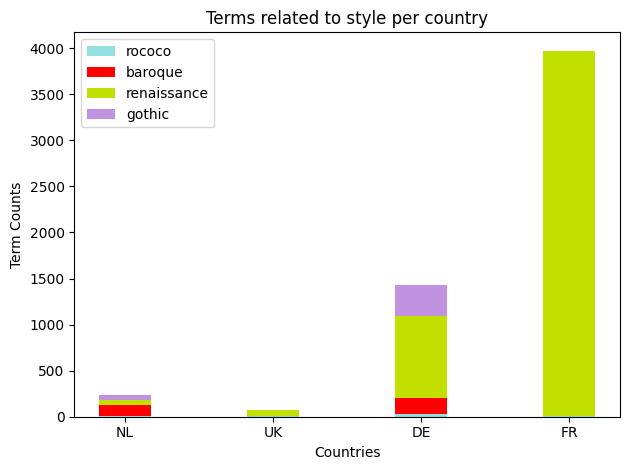

In [98]:
# Visualize the term count as a stacked bar chart per country
terms = list_to_count[number_of_terms:number_of_terms*2] # change which list is visualized

# Create a list of countries (y-axis labels)
countries = list(term_count_dict.keys())

# Create the stacked bar chart
width = 0.35  # Width of the bars

fig, ax = plt.subplots()

bottom = np.zeros(len(countries))
colors = ['#92E0E0', 'red', '#C1E000', '#C192E0']
for term_index in range(len(terms)):
    term_counts = [term_count_dict[country][term_index] for country in countries]
    ax.bar(countries, term_counts, width, label=terms[term_index], bottom=bottom,
           color=colors[term_index % len(colors)])
    bottom += np.array(term_counts)

ax.set_xlabel('Countries')
ax.set_ylabel('Term Counts')
ax.set_title('Terms related to style per country')
ax.legend()

plt.tight_layout()
plt.show()

In [94]:
styles[number_of_terms:number_of_terms*2]

['rococo', 'baroque', 'renaissance', 'gothic']